<a href="https://colab.research.google.com/github/mrdbourke/cs329s-ml-deployment-tutorial/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's train some models we can deploy...

Model code to go along with [CS329s machine learning model deployment tutorial](https://github.com/mrdbourke/cs329s-ml-deployment-tutorial). 

* **Want:** [`SavedModel`](https://www.tensorflow.org/guide/saved_model) format to upload to Google Storage (GS).
* **Data:** Different slices of [Food101 dataset](https://www.kaggle.com/dansbecker/food-101).
* **Model(s):** [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) backbone's with different output layers (e.g. 10 classes, 11 classes, 12 classes).


In [1]:
# Are we using a GPU? If not: go to Runtime -> Change runtime type -> Hardware accelerator: GPU
!nvidia-smi

Sun Feb 14 05:54:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

If the cell above doesn't output something which looks like:

```
Fri Sep  4 03:35:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+
```

Go to Runtime -> Change Runtime Type -> Hardware Accelerator and select "GPU", then rerun the cell above.

## Setup helper functions

In [2]:
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Unzip the downloaded file
def unzip_data(filename):
  """
  Utility function to unzip a zipped file.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [3]:
# Setup data inputs
IMG_SIZE = (224, 224)

def create_data_loaders(train_dir, test_dir, image_size=IMG_SIZE):
  """
  Creates a training and test image BatchDataset from train_dir and test_dir.
  """
  train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)
  # Note: the test data is the same as the previous experiment, we could
  # skip creating this, but we'll leave this here to practice.
  test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)
  
  return train_data, test_data

In [4]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [5]:
# Setup input shape and base model, freezing the base model layers
INPUT_SHAPE = (224, 224, 3)
BASE_MODEL = tf.keras.applications.EfficientNetB0(include_top=False)

def create_model(input_shape=INPUT_SHAPE, base_model=BASE_MODEL, num_classes=10):
  # Fine-tune?
  base_model.trainable = False

  # Create input layer
  inputs = layers.Input(shape=input_shape, name="input_layer")

  # Add in data augmentation Sequential model as a layer
  x = data_augmentation(inputs)

  # Give base_model inputs (after augmentation) and don't train it
  x = base_model(x, training=False)

  # Pool output features of base model
  x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

  # Put a dense layer on as the output
  outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

  # Make a model with inputs and outputs
  model = keras.Model(inputs, outputs)

  # Compile the model
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
  return model

16711680/16705208 [==============================] - 0s 0us/step


In [6]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  if scale:
    return img/255.
  else:
    return img

## Download data

In [7]:
# Get data
import zipfile

# Download data (10 class subset of Food101 - https://www.kaggle.com/dansbecker/food-101)
# Already formatted in standard image classification directory style
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2021-02-14 05:54:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519184959 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  93.4MB/s    in 5.3s    

2021-02-14 05:54:58 (93.4 MB/s) - ‘10_food_classes_all_data.zip’ saved [519184959/519184959]



In [8]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [9]:
# Check the file in 10_food_classes_10_percent
!ls -la 10_food_classes_all_data

total 28
drwxr-xr-x  4 root root 4096 Feb 14 05:54 .
drwxr-xr-x  1 root root 4096 Feb 14 05:54 ..
-rw-r--r--  1 root root 8196 Feb 14 05:54 .DS_Store
drwxr-xr-x 12 root root 4096 Feb 14 05:54 test
drwxr-xr-x 12 root root 4096 Feb 14 05:54 train


In [ ]:
## That one pesky file that always gets stuck
#!rm 10_food_classes_10_percent/.DS_Store

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Because you're likely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:
* `dir_name` is the overall logs directory
* `experiment_name` is the particular experiment
* `current_timestamp` is the time the experiment started based on Python's [`datetime.datetime().now()`](https://docs.python.org/3/library/datetime.html#datetime.datetime.now)

> 🔑 **Note:** Depending on your use case, the above experimenting tracking naming method may work or you might require something more specific. The good news is, the TensorBoard callback makes it easy to track modelling logs as long as you specify where to track them. So you can get as creative as you like with how you name your experiments, just make sure you or your team can understand them.



## Model 1 (10 classes)

In [ ]:
# Create BatchDataset
train_data, test_data = create_data_loaders(train_dir="10_food_classes_all_data/train/",
                                            test_dir="10_food_classes_all_data/test/")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# What size is our data?
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Create model
model_1 = create_model(num_classes=len(train_data.class_names))

# Fit the model
history_1_percent = model_1.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "all_data_aug")])

Saving TensorBoard log files to: transfer_learning/all_data_aug/20210210-231226
Epoch 1/5
235/235 [==============================] - 71s 255ms/step - loss: 1.4620 - accuracy: 0.5484 - val_loss: 0.5066 - val_accuracy: 0.8536
Epoch 2/5
235/235 [==============================] - 50s 211ms/step - loss: 0.7201 - accuracy: 0.7819 - val_loss: 0.4265 - val_accuracy: 0.8569
Epoch 3/5
235/235 [==============================] - 47s 199ms/step - loss: 0.6176 - accuracy: 0.8028 - val_loss: 0.4116 - val_accuracy: 0.8618
Epoch 4/5
235/235 [==============================] - 47s 199ms/step - loss: 0.5606 - accuracy: 0.8227 - val_loss: 0.4060 - val_accuracy: 0.8602
Epoch 5/5
235/235 [==============================] - 45s 189ms/step - loss: 0.5435 - accuracy: 0.8308 - val_loss: 0.3677 - val_accuracy: 0.8750


In [ ]:
# Get an image Tensor
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg

--2021-02-10 23:18:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.1s    

2021-02-10 23:18:11 (27.7 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



In [ ]:
# Classes our model is trained on
class_names = train_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Preprocess image
pizza_img = load_and_prep_image("03-pizza-dad.jpeg")
pizza_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 73.625,  76.75 ,  67.125],
        [114.   , 122.   , 101.   ],
        [146.875, 151.875, 129.875],
        ...,
        [ 14.5  ,  17.5  ,  10.5  ],
        [ 14.25 ,  19.25 ,  12.25 ],
        [ 19.75 ,  22.75 ,  15.75 ]],

       [[239.125, 243.625, 246.125],
        [225.375, 232.125, 234.875],
        [240.   , 245.   , 244.5  ],
        ...,
        [ 11.   ,  14.   ,   7.   ],
        [ 20.   ,  23.   ,  16.   ],
        [ 20.875,  25.875,  18.875]],

       [[ 32.5  ,  34.5  ,  31.5  ],
        [ 44.625,  44.5  ,  42.375],
        [ 33.   ,  38.   ,  34.   ],
        ...,
        [  8.75 ,  13.25 ,   6.25 ],
        [ 14.875,  17.875,  10.875],
        [ 13.625,  20.625,  12.625]],

       ...,

       [[ 61.875,  40.875,  19.875],
        [ 60.   ,  42.   ,  22.   ],
        [ 61.   ,  43.   ,  21.   ],
        ...,
        [134.5  ,  96.125,  60.75 ],
        [104.875,  69.375,  43.125],
        [106.25 ,  75.2

In [ ]:
# Make predictions
pizza_expanded = tf.expand_dims(pizza_img, axis=0) # expand image dimensions (224, 224, 3) -> (1, 224, 224, 3)
pred = model_1.predict(pizza_expanded)
pred

array([[8.2119545e-03, 3.3304928e-05, 6.2837714e-04, 1.6367142e-04,
        3.0865319e-06, 5.1294103e-07, 9.9020046e-01, 1.2048778e-04,
        5.5204531e-05, 5.8289926e-04]], dtype=float32)

In [ ]:
# Check the predicted class
class_names[tf.argmax(pred[0])]

'pizza'

## Save and upload Model 1 to Google Storage

We want to save our model in the TensorFlow [`SavedModel`](https://www.tensorflow.org/guide/saved_model) format because:
  * We're going to upload our `SavedModel` to Google Storage.
  * Then we're link our `SavedModel` to AI platform to serve it ([AI platform requires `SavedModel`](https://cloud.google.com/ai-platform/prediction/docs/deploying-models) format for model serving).

We can do this using: 
1. `model.save("PATH_TO_SAVED_MODEL")` to create a `SavedModel` object (our trained model).
2. Upload the model to Google Storage using the following guide: https://cloud.google.com/storage/docs/uploading-objects#gsutil 

In [ ]:
# Save model_1
model_1.save("efficientnet_model_1_10_classes")

INFO:tensorflow:Assets written to: efficientnet_model_1_10_classes/assets


The next few cells will allow you to upload files directly from Google Colab to Google Storage.

In [ ]:
# Authentic Colab 
# (running this will give you a code to authentic your Google Colab instance, keep the code secret)
from google.colab import auth
auth.authenticate_user()

When you run the cell below, it'll ask you a bunch of questions about setting up `gcloud`, here's an example and the answers I chose (you'll want to change the project to your specific Google Cloud project):

```
#  [1] Re-initialize this configuration [default] with new settings 
#  [2] Create a new configuration
# Please enter your numeric choice:  1

# Choose the account you would like to use to perform operations for 
# this configuration:
#  [1] daniel@mrdbourke.com
#  [2] Log in with a new account
# Please enter your numeric choice:  1

# Pick cloud project to use: 
#  [1] airbnb-amenity-detection
#  [2] auto-ml-dog-vision
#  [3] auto-ml-dog-vision-test
#  [4] daniels-dl-playground
#  [5] ml-kit-codelab-demo
#  [6] nutrify-v0
#  [7] tf-course
#  [8] Create a new project
# Please enter numeric choice or text value (must exactly match list 
# item):  4

# Do you want to configure a default Compute Region and Zone? (Y/n)?  n
```

In [ ]:
# Install and initialize the gcloud command line tool - https://cloud.google.com/sdk/docs/install
# (this will give you access to gcloud tools within Colab)
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

Once you've gone through the steps in the above cell, you'll be able to use `gcloud` utilities from Colab.

The main one we're after is copying our model from Colab storage to Google Storage.

For example, running:

```
# Copy local model folder to bucket named "ml_deployment_lec_bucket_0"
!gsutil cp -r efficientnet_model_1_10_classes gs://ml_deploymet_lec_bucket_0
```

But the above line uses my Google Storage bucket/model, yours will look more like:

```
!gsutil cp -r YOUR_MODEL_NAME gs://YOUR_BUCKET_NAME
```

**Note:** To upload anything to a bucket, you will need an existing bucket. See the documentation on [how to create a Google Storage bucket](https://cloud.google.com/storage/docs/creating-buckets).

In [ ]:
# Copy model to bucket - https://cloud.google.com/storage/docs/uploading-objects#gsutil 
# Use "-r" for folders (r stands for recursive)
!gsutil cp -r efficientnet_model_1_10_classes gs://ml_deploymet_lec_bucket_0

Copying file://efficientnet_model_1_10_classes/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1_10_classes/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1_10_classes/variables/variables.index [Content-Type=application/octet-stream]...
\
Operation completed over 3 objects/22.1 MiB.                                     


In [ ]:
# Copy model to bucket
!gsutil cp -r efficientnet_model_1_10_classes gs://cs329s_live_bucket_creation

Copying file://efficientnet_model_1_10_classes/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1_10_classes/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1_10_classes/variables/variables.index [Content-Type=application/octet-stream]...
- [3 files][ 22.1 MiB/ 22.1 MiB]                                                
Operation completed over 3 objects/22.1 MiB.                                     


In [ ]:
# # Download model (to upload to GS, you could probably use gcloud cli here but whatever)
# !zip -r /content/efficientnet_model_0_10_classes.zip /content/efficientnet_model_0_10_classes
# from google.colab import files
# files.download("/content/efficientnet_model_0_10_classes.zip")

## Model 2 (11 food classes)

Same as model 1 but we've added the donut class.

In [ ]:
# Get data
import zipfile

# Download data
!wget https://storage.googleapis.com/ml_deploymet_lec_bucket_0/11_food_classes_all_data.zip # note: this may be broken if using well beyond Feb 10 2021
unzip_data("11_food_classes_all_data.zip")

--2021-02-02 07:20:31--  https://storage.googleapis.com/ml_deploymet_lec_bucket_0/11_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 570914387 (544M) [application/zip]
Saving to: ‘11_food_classes_all_data.zip.1’

11_food_classes_all 100%[===================>] 544.47M   283MB/s    in 1.9s    

2021-02-02 07:20:33 (283 MB/s) - ‘11_food_classes_all_data.zip.1’ saved [570914387/570914387]



In [ ]:
# Create data loaders
train_data, test_data = create_data_loaders(train_dir="11_food_classes_all_data/train/",
                                            test_dir="11_food_classes_all_data/test/")

Found 8250 files belonging to 11 classes.
Found 2750 files belonging to 11 classes.


In [ ]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'donuts',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Create model
model_2 = create_model(num_classes=len(train_data.class_names))

# Fit model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)))

Epoch 1/5
258/258 [==============================] - 76s 249ms/step - loss: 1.4867 - accuracy: 0.5498 - val_loss: 0.5164 - val_accuracy: 0.8497
Epoch 2/5
258/258 [==============================] - 56s 214ms/step - loss: 0.7410 - accuracy: 0.7740 - val_loss: 0.4438 - val_accuracy: 0.8601
Epoch 3/5
258/258 [==============================] - 52s 199ms/step - loss: 0.6339 - accuracy: 0.8005 - val_loss: 0.3787 - val_accuracy: 0.8765
Epoch 4/5
258/258 [==============================] - 50s 192ms/step - loss: 0.5804 - accuracy: 0.8139 - val_loss: 0.3722 - val_accuracy: 0.8720
Epoch 5/5
258/258 [==============================] - 48s 185ms/step - loss: 0.5594 - accuracy: 0.8187 - val_loss: 0.3605 - val_accuracy: 0.8780


In [ ]:
pizza_expanded = tf.expand_dims(pizza_img, axis=0)
pred = model_2.predict(pizza_expanded)
pred

array([[9.0466682e-03, 4.5336943e-05, 9.9710169e-06, 6.5794133e-04,
        3.1481599e-04, 3.2332186e-06, 2.0485681e-06, 9.8864961e-01,
        2.1775642e-04, 4.8929705e-05, 1.0036530e-03]], dtype=float32)

In [ ]:
# Save model_2...
model_2.save("efficientnet_model_2_11_classes")

INFO:tensorflow:Assets written to: efficientnet_model_2_11_classes/assets


## Upload Model 2 to Google Storage

In [ ]:
# Auth Colab
from google.colab import auth
auth.authenticate_user()
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

In [ ]:
# Upload to GS (requires auth)
!gsutil cp -r efficientnet_model_2_11_classes gs://ml_deploymet_lec_bucket_0

Copying file://efficientnet_model_2_11_classes/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_2_11_classes/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_2_11_classes/variables/variables.index [Content-Type=application/octet-stream]...
- [3 files][ 22.1 MiB/ 22.1 MiB]                                                
Operation completed over 3 objects/22.1 MiB.                                     


## Model 3 (11 food classes + 5000 non-food images, 12 classes total)

* 11 food classes are same as model 2 above.
* 1 `not_food` class is comprised of ~5000 randomly downloaded images from ImageNet (500 random classes and 10 random images within each of those classes).
  * To do this, I used the script at: https://github.com/mf1024/ImageNet-Datasets-Downloader 

In [ ]:
# Get data
import zipfile

# Download data
!wget https://storage.googleapis.com/ml_deploymet_lec_bucket_0/11_food_classes_plus_not_food_class_all_data.zip # note: this may be broken if using well beyond Feb 10 2021
unzip_data("11_food_classes_plus_not_food_class_all_data.zip")

In [ ]:
# Create data loaders
train_data, test_data = create_data_loaders(train_dir="11_food_classes_plus_not_food_class_all_data/train/",
                                            test_dir="11_food_classes_plus_not_food_class_all_data/test/")

Found 14343 files belonging to 12 classes.
Found 4273 files belonging to 12 classes.


In [ ]:
# Create model
model_3 = create_model(num_classes=len(train_data.class_names))

# Fit model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)))

Epoch 1/5
449/449 [==============================] - 117s 235ms/step - loss: 1.2646 - accuracy: 0.6447 - val_loss: 0.5087 - val_accuracy: 0.8778
Epoch 2/5
449/449 [==============================] - 88s 195ms/step - loss: 0.6192 - accuracy: 0.8225 - val_loss: 0.4408 - val_accuracy: 0.8873
Epoch 3/5
449/449 [==============================] - 84s 186ms/step - loss: 0.5418 - accuracy: 0.8443 - val_loss: 0.4145 - val_accuracy: 0.8864
Epoch 4/5
449/449 [==============================] - 78s 173ms/step - loss: 0.5053 - accuracy: 0.8512 - val_loss: 0.4024 - val_accuracy: 0.8864
Epoch 5/5
449/449 [==============================] - 77s 170ms/step - loss: 0.4768 - accuracy: 0.8578 - val_loss: 0.3706 - val_accuracy: 0.8873


In [ ]:
# Save model_3...
model_3.save("efficientnet_model_3_12_classes")

INFO:tensorflow:Assets written to: efficientnet_model_3_12_classes/assets


In [ ]:
model_3.evaluate(test_data)

134/134 [==============================] - 17s 124ms/step - loss: 0.4300 - accuracy: 0.8781


[0.4300059676170349, 0.8780716061592102]

## Upload Model 3 to Google Storage

In [ ]:
# Auth Colab
from google.colab import auth
auth.authenticate_user()
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

In [ ]:
# Upload to GS (requires auth)
!gsutil cp -r efficientnet_model_3_12_classes gs://ml_deploymet_lec_bucket_0

Copying file://efficientnet_model_3_12_classes/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_3_12_classes/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_3_12_classes/variables/variables.index [Content-Type=application/octet-stream]...
- [3 files][ 22.1 MiB/ 22.1 MiB]                                                
Operation completed over 3 objects/22.1 MiB.                                     


## Get test non-food image and make predictions

In [14]:
!wget https://raw.githubusercontent.com/mrdbourke/cs329s-ml-deployment-tutorial/main/food-images/plant.jpeg

--2021-02-14 06:02:51--  https://raw.githubusercontent.com/mrdbourke/cs329s-ml-deployment-tutorial/main/food-images/plant.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542790 (530K) [image/jpeg]
Saving to: ‘plant.jpeg’

plant.jpeg          100%[===================>] 530.07K  --.-KB/s    in 0.03s   

2021-02-14 06:02:51 (17.9 MB/s) - ‘plant.jpeg’ saved [542790/542790]



In [ ]:
plant = load_and_prep_image("plant.jpeg")
plant = tf.cast(tf.round(plant), dtype=tf.int32)
plant

<tf.Tensor: shape=(224, 224, 3), dtype=int32, numpy=
array([[[110,  96,  95],
        [107,  93,  92],
        [ 88,  74,  71],
        ...,
        [141, 155, 164],
        [207, 210, 209],
        [242, 241, 237]],

       [[117, 106, 104],
        [117, 106, 103],
        [116, 105, 101],
        ...,
        [132, 144, 152],
        [207, 207, 208],
        [202, 199, 201]],

       [[107,  96,  92],
        [119, 108, 104],
        [102,  91,  87],
        ...,
        [177, 187, 189],
        [206, 204, 202],
        [204, 200, 197]],

       ...,

       [[ 20,  70,  49],
        [ 37,  79,  57],
        [111, 159, 133],
        ...,
        [122, 175, 142],
        [ 84, 143, 110],
        [ 49, 116,  80]],

       [[120, 154, 131],
        [137, 164, 147],
        [108, 127, 111],
        ...,
        [103, 169, 133],
        [ 46,  95,  66],
        [ 83, 143, 110]],

       [[ 43,  83,  62],
        [ 20,  49,  31],
        [ 33,  74,  54],
        ...,
        [ 53, 117,  8

In [ ]:
model_3.predict(tf.expand_dims(plant, axis=0))

array([[1.14653085e-04, 3.54328367e-04, 1.86755587e-05, 5.58937667e-04,
        2.95464328e-04, 4.18224517e-04, 1.86513625e-02, 9.65816736e-01,
        2.96051439e-05, 6.32123483e-05, 6.92888675e-03, 6.74987910e-03]],
      dtype=float32)

# Make and plot test predictions

In [ ]:
import matplotlib.pyplot as plt

def pred_and_plot(model, image, class_names):
  pred_probs = model.predict(tf.expand_dims(image, axis=0))
  pred_class = class_names[tf.argmax(pred_probs[0])]
  
  plt.figure()
  plt.imshow(image)
  plt.title(f"{pred_class}, prob: {tf.reduce_max(pred_probs):.2f}")
  plt.axis(False);

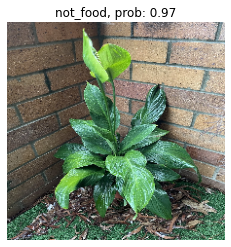

In [ ]:
pred_and_plot(model=model_3,
              image=plant,
              class_names=train_data.class_names)

In [ ]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'donuts',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'not_food',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 4 (experiment)

Going to use same model as #3 but try mixed precision training and see what happens.

See: https://www.tensorflow.org/guide/mixed_precision

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6c111d17-da04-3fff-27c9-ca59a1321b70)


In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print(tf.__version__)

2.4.1


In [ ]:
# Set mixed precision to float16 & float32
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
# Get data
import zipfile

# Download data
!wget https://storage.googleapis.com/ml_deploymet_lec_bucket_0/11_food_classes_plus_not_food_class_all_data.zip # note: this may be broken if using well beyond Feb 10 2021
unzip_data("11_food_classes_plus_not_food_class_all_data.zip")

--2021-02-03 23:44:36--  https://storage.googleapis.com/ml_deploymet_lec_bucket_0/11_food_classes_plus_not_food_class_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1053780900 (1005M) [application/zip]
Saving to: ‘11_food_classes_plus_not_food_class_all_data.zip.1’

11_food_classes_plu 100%[===================>]   1005M   202MB/s    in 4.9s    

2021-02-03 23:44:41 (204 MB/s) - ‘11_food_classes_plus_not_food_class_all_data.zip.1’ saved [1053780900/1053780900]



In [ ]:
# Create data loaders
train_data, test_data = create_data_loaders(train_dir="11_food_classes_plus_not_food_class_all_data/train/",
                                            test_dir="11_food_classes_plus_not_food_class_all_data/test/")

Found 14343 files belonging to 12 classes.
Found 4273 files belonging to 12 classes.


In [ ]:
train_data.take(1)

<TakeDataset shapes: ((None, 224, 224, 3), (None, 12)), types: (tf.float32, tf.float32)>

In [ ]:
# Create model (with mixed precision training)
def create_model(input_shape=INPUT_SHAPE, base_model=BASE_MODEL, num_classes=10):
  # Fine-tune?
  base_model.trainable = False

  # Create input layer
  inputs = layers.Input(shape=input_shape, name="input_layer")

  # Add in data augmentation Sequential model as a layer
  x = data_augmentation(inputs)

  # Give base_model inputs (after augmentation) and don't train it
  x = base_model(x, training=False)

  # Pool output features of base model
  x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

  # Put a dense layer on as the output
  x = layers.Dense(num_classes, name="dense_layer")(x)

  print(x.dtype)

  ## NOTE: Mixed precision requires a separate output activation
  outputs = layers.Activation(activation="softmax", dtype=tf.float32, name="predictions")(x)

  print(outputs.dtype)
  
  # Make a model with inputs and outputs
  model = keras.Model(inputs, outputs)

  # Compile the model
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
  return model

model_4 = create_model(num_classes=len(train_data.class_names))

<dtype: 'float16'>
<dtype: 'float32'>


In [ ]:
model_4.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
dense_layer (Dense)          (None, 12)                15372     
_________________________________________________________________
predictions (Activation)     (None, 12)                0         
Total params: 4,064,943
Trainable params: 15,372
Non-trainable params: 4,049,571
____________________________________________

In [ ]:
print(model_4.layers[3].dtype)
print(model_4.layers[3].dtype_policy)

float32
<Policy "mixed_float16">


In [ ]:
# Fit model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)))

Epoch 1/5
449/449 [==============================] - 70s 131ms/step - loss: 1.2719 - accuracy: 0.6387 - val_loss: 0.5272 - val_accuracy: 0.8665
Epoch 2/5
449/449 [==============================] - 57s 126ms/step - loss: 0.6092 - accuracy: 0.8274 - val_loss: 0.4533 - val_accuracy: 0.8788
Epoch 3/5
449/449 [==============================] - 57s 126ms/step - loss: 0.5427 - accuracy: 0.8433 - val_loss: 0.4074 - val_accuracy: 0.8883
Epoch 4/5
449/449 [==============================] - 57s 127ms/step - loss: 0.4959 - accuracy: 0.8554 - val_loss: 0.4069 - val_accuracy: 0.8949
Epoch 5/5
449/449 [==============================] - 57s 126ms/step - loss: 0.4815 - accuracy: 0.8568 - val_loss: 0.4127 - val_accuracy: 0.8807


In [ ]:
## Model 3 (not mixed precision)
# Epoch 1/5
# 449/449 [==============================] - 117s 235ms/step - loss: 1.2646 - accuracy: 0.6447 - val_loss: 0.5087 - val_accuracy: 0.8778
# Epoch 2/5
# 449/449 [==============================] - 88s 195ms/step - loss: 0.6192 - accuracy: 0.8225 - val_loss: 0.4408 - val_accuracy: 0.8873
# Epoch 3/5
# 449/449 [==============================] - 84s 186ms/step - loss: 0.5418 - accuracy: 0.8443 - val_loss: 0.4145 - val_accuracy: 0.8864
# Epoch 4/5
# 449/449 [==============================] - 78s 173ms/step - loss: 0.5053 - accuracy: 0.8512 - val_loss: 0.4024 - val_accuracy: 0.8864
# Epoch 5/5
# 449/449 [==============================] - 77s 170ms/step - loss: 0.4768 - accuracy: 0.8578 - val_loss: 0.3706 - val_accuracy: 0.8873